# Circuits

---
**Task**: Classify if a given Graph is connected or disconnected.
This should be independet of the representation of the graph and thus invariant under Permutations.

---

## Data
**Input space** (set of adjacency matrices):
$$\mathcal{X}=\mathbb{B}^{n\times n}$$
**Target space**:
$$\mathcal{Y}=\{1,-1\}\qquad \text{where}\qquad y^{(i)}=\begin{cases}1 &\text{if connected}\\-1&\text{else}\end{cases}$$

# Circuit

```
    ┌─────────────┐    ┌────────┐    ┌─────────────┐
----│ Feature Map |----| Ansatz |----| Measurement |----
    └─────────────┘    └────────┘    └─────────────┘
```

In order to embed an adjecency matrix, I used the schema of [qiskit](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.GraphState).
Also, I used the ansatz of [Theoretical Guarantees for Permutation-Equivariant Quantum Neural Networks](https://arxiv.org/pdf/2210.09974.pdf).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from typing import Iterable
from functools import reduce

import pennylane as qml
import torch
from pennylane import numpy as np

from src import utils

num_qubits = 6 # a qubit for each node (see :func: `~graph_state`)
dataset = utils.load_patterns("./data/graph_connectedness/nodes_6-graphs_3000-edges_5_6_7.pt", num_nodes=6)
X, Y = dataset.tensors
dev = qml.device("lightning.qubit", wires=num_qubits)
print(f"We have {num_qubits} qubits")

We have 6 qubits


In [3]:
def get_num_qubits_from_inputs(inputs: torch.Tensor) -> int:
    """Returns the number of qubits which are needed for embedding the inputs."""
    if inputs.ndim == 1:
        dimension, = inputs.shape
        return int(math.sqrt(dimension))
    elif inputs.ndim == 2:
        _, dimension = inputs.shape
        return int(math.sqrt(dimension))
    raise ValueError(
        "Inputs are expected to be of size (num_batches, num_nodes*num_nodes)"
        "or (num_nodes*num_nodes,)."
    )

In [4]:
def layer(*, rx_weight: torch.Tensor, ry_weight: torch.Tensor, zz_weight: torch.Tensor, num_qubits: int) -> None:
    """Adds a single layer wich is equivariant under the aciton of S_n."""
    # Use different names for each iteration. This way mypy can infer diferrent
    # types.
    for i in range(num_qubits):
        qml.RX(rx_weight, wires=i)
    for j in range(num_qubits):
        qml.RY(ry_weight, wires=j)
    for m, n in torch.t(torch.triu_indices(num_qubits, num_qubits, offset=1)):
        qml.IsingZZ(zz_weight, wires=[m.item(), n.item()])

In [5]:
def graph_state(inputs: torch.Tensor, num_qubits: int) -> None:
    """Embeds the input into a graph state.

    Each qubit represents a node in the graph. Fist, the qubits are mapped to
    the |+> state. Second, if an edge exists between node i and j, we apply a
    controlled Z Gate.

    It is expected that the n times n adjacency matrix was converted to a
    one dimensional n * n tensor. This is due the fact that a n times n tensor
    is interpreted as a batch of size n with feature vectors of n features by
    pytorch and pennylane.
    
    In order to use pennylanes native batching support we add an "controlled
    identity gate" if no edge is present and an controlled z gate if an edge is
    present.
    """
    if inputs.ndim == 1:
        inputs = inputs.reshape(1, num_qubits, num_qubits)
    elif inputs.ndim == 2: # batched input
        inputs = inputs.reshape(inputs.shape[0], num_qubits, num_qubits)
    else:
        raise ValueError(
            "Inputs are expected to be of size (num_batches, num_nodes*num_nodes)"
            "or (num_nodes*num_nodes,)."
        )
    # Use different names for each iteration. This way mypy can infer diferrent
    # types.
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    for m, n in torch.t(torch.triu_indices(num_qubits, num_qubits, offset=1)):
        # we get the e^(i*0) == 1 for inputs[k, m.item(), n.item()] == 0 and
        # exp(i*pi) == -1 for inputs[k, m.item(), n.item()] == 1
        qml.ControlledPhaseShift(np.pi*inputs[:, m.item(), n.item()], wires=[m.item(), n.item()])

In [6]:
def multi_pauliz(num_qubits: int) -> qml.operation.Tensor:
    """Build the observable Z tensor ... tensor Z."""
    observable = qml.PauliZ(0)
    for i in range(1, num_qubits):
        observable = observable @ qml.PauliZ(i)
    return observable

In [7]:
def extended_Sn_layer(*, rx_weight: torch.Tensor, ry_weight: torch.Tensor, zz_weight: torch.Tensor, num_qubits: int) -> None:
    """Adds a single layer wich is equivariant under the aciton of S_n."""
    # Use different names for each iteration. This way mypy can infer diferrent
    # types.
    for i in range(num_qubits):
        qml.RX(rx_weight[i], wires=i)
    for j in range(num_qubits):
        qml.RY(ry_weight, wires=j)
    for m, n in torch.t(torch.triu_indices(num_qubits, num_qubits, offset=1)):
        qml.IsingZZ(zz_weight, wires=[m.item(), n.item()])

In [8]:
@qml.qnode(dev, interface="torch")
def test_extended_Sn_circuit(inputs: torch.Tensor, weights: torch.Tensor, e_weights: torch.Tensor) -> torch.Tensor:
    """Create the permutation equivariant circuit for graph predictions.

    The number of layers is determined by the first dimension of the weights
    tensor.

    We return the expectation value(s) of the supplied observable according to
    the number of batches.

    Example:
        import pennylane as qml

        from src import circuit

        num_qubits = 6
        num_layers = 5
        dev = qml.device("default.qubit.torch", wires=num_qubits)
        weight_shapes = {"weights": (num_layers, 3), "e_weights": (num_qubits,)}
        Sn_circuit = qml.QNode(circuit.Sn_circuit, device=dev, interface="torch")
        model = qml.qnn.TorchLayer(Sn_circuit, weight_shapes)
    """
    num_qubits = get_num_qubits_from_inputs(inputs)

    graph_state(inputs, num_qubits)

    if weights.ndim != 2 or weights.shape[1] != 3:
        raise ValueError("Weights are expected to have dimension (num_layers, 3).")
    if e_weights.ndim != 1 or e_weights.shape[0] != num_qubits:
        raise ValueError("Extended weights are expected to have dimension (num_qubits,).")
    num_layers, _ = weights.shape
    for layer_index in range(num_layers):
        layer(
            rx_weight=weights[layer_index, 0],
            ry_weight=weights[layer_index, 1],
            zz_weight=weights[layer_index, 2],
            num_qubits=num_qubits,
        )
    for i in range(num_qubits):
        qml.RX(e_weights[i], wires=i)
    return qml.expval(multi_pauliz(num_qubits))

In [9]:
@qml.qnode(dev, interface="torch")
def extended_Sn_circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    """Create the permutation equivariant circuit for graph predictions.

    The number of layers is determined by the first dimension of the weights
    tensor.

    We return the expectation value(s) of the supplied observable according to
    the number of batches.

    Example:
        import pennylane as qml

        from src import circuit

        num_qubits = 6
        num_layers = 5
        dev = qml.device("default.qubit.torch", wires=num_qubits)
        weight_shapes = {"weights": (num_layers, num_qubits + 2)}
        Sn_circuit = qml.QNode(circuit.Sn_circuit, device=dev, interface="torch")
        model = qml.qnn.TorchLayer(Sn_circuit, weight_shapes)
    """
    num_qubits = get_num_qubits_from_inputs(inputs)

    graph_state(inputs, num_qubits)

    if weights.ndim != 2 or weights.shape[1] != num_qubits + 2:
        raise ValueError("Weights are expected to have dimension (num_layers, num_qubits + 2).")
    num_layers, _ = weights.shape
    for layer_index in range(num_layers):
        extended_Sn_layer(
            rx_weight=weights[layer_index, :num_qubits],
            ry_weight=weights[layer_index, -2],
            zz_weight=weights[layer_index, -1],
            num_qubits=num_qubits,
        )
    return qml.expval(multi_pauliz(num_qubits))

In [6]:
@qml.qnode(dev, interface="torch")
def Sn_circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    """Create the permutation equivariant circuit for graph predictions.

    The number of layers is determined by the first dimension of the weights
    tensor.

    We return the expectation value(s) of the supplied observable according to
    the number of batches.

    Example:
        import pennylane as qml

        from src import circuit

        num_qubits = 6
        num_layers = 5
        dev = qml.device("default.qubit.torch", wires=num_qubits)
        weight_shapes = {"weights": (num_layers, 3)}
        Sn_circuit = qml.QNode(circuit.Sn_circuit, device=dev, interface="torch")
        model = qml.qnn.TorchLayer(Sn_circuit, weight_shapes)
    """
    num_qubits = get_num_qubits_from_inputs(inputs)

    graph_state(inputs, num_qubits)

    if weights.ndim != 2 or weights.shape[1] != 3:
        raise ValueError("Weights are expected to have dimension (num_layers, 3).")
    num_layers, _ = weights.shape
    for layer_index in range(num_layers):
        layer(
            rx_weight=weights[layer_index, 0],
            ry_weight=weights[layer_index, 1],
            zz_weight=weights[layer_index, 2],
            num_qubits=num_qubits,
        )
    return qml.expval(multi_pauliz(num_qubits))

In [7]:
@qml.qnode(dev, interface="torch")
def entanglement_circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    """Create the entanglement circuit for graph predictions.

    The number of layers is determined by the first dimension of the weights
    tensor.

    We return the expectation value(s) of the supplied observable according to
    the number of batches.

    Example:
        import pennylane as qml

        from src import circuit

        num_layers = 5
        num_qubits = 6
        dev = qml.device("default.qubit.torch", wires=num_qubits)
        weight_shapes = {"weights": (num_layers, num_qubits)}
        entanglement_circuit = qml.QNode(circuit.entanglement_circuit, device=dev, interface="torch")

        model = qml.qnn.TorchLayer(entanglement_circuit, weight_shapes)
    """
    num_qubits = get_num_qubits_from_inputs(inputs)
    graph_state(inputs, num_qubits)

    if weights.ndim != 2 or weights.shape[1] != num_qubits:
        raise ValueError("Weights are expected to have dimension (num_layers, num_qubits).")
    qml.BasicEntanglerLayers(weights=weights, wires=range(num_qubits))

    return qml.expval(multi_pauliz(num_qubits))

In [8]:
@qml.qnode(dev, interface="torch")
def strongly_entanglement_circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    """Create the strongly entanglement circuit for graph predictions.

    The number of layers is determined by the first dimension of the weights
    tensor.

    We return the expectation value(s) of the supplied observable according to
    the number of batches.

    Example:
        import pennylane as qml

        from src import circuit

        num_layers = 5
        num_qubits = 6
        weight_shapes = {"weights": (num_layers, num_qubits, 3)}
        strongly_entanglement_circuit = qml.QNode(circuit.strongly_entanglement_circuit, dev=dev, interface="torch")
        model = qml.qnn.TorchLayer(strongly_entanglement_circuit, weight_shapes)
    """
    num_qubits = get_num_qubits_from_inputs(inputs)
    graph_state(inputs, num_qubits)

    if weights.ndim != 3 or weights.shape[1] != num_qubits or weights.shape[2] != 3:
        raise ValueError("Weights are expected to have dimension (num_layers, num_qubits, 3).")
    num_layers = weights.shape[0]
    ranges = tuple((l % (2)) + 1 for l in range(num_layers))
    qml.StronglyEntanglingLayers(weights=weights, wires=range(num_qubits), ranges=ranges)

    return qml.expval(multi_pauliz(num_qubits))

In [9]:
def Cn_layer(*, rx_weight: torch.Tensor, ry_weight: torch.Tensor, zz_weight: torch.Tensor, num_qubits: int) -> None:
    """Adds a single layer wich is equivariant under the aciton of C_n."""
    # Use different names for each iteration. This way mypy can infer diferrent
    # types.
    for i in range(num_qubits):
        qml.RX(rx_weight, wires=i)
    for j in range(num_qubits):
        qml.RY(ry_weight, wires=j)
    for m, n in zip(range(num_qubits-1), range(1, num_qubits)):
        qml.IsingZZ(zz_weight, wires=[m, n])
    qml.IsingZZ(zz_weight, wires=[num_qubits - 1, 0])

In [10]:
@qml.qnode(dev, interface="torch")
def Cn_circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    """Create a circuit which is invariant under cyclic permutations.

    The number of layers is determined by the first dimension of the weights
    tensor.

    We return the expectation value(s) of the supplied observable according to
    the number of batches.

    Example:
        import pennylane as qml

        from src import circuit

        num_qubits = 6
        num_layers = 5
        dev = qml.device("default.qubit.torch", wires=num_qubits)
        weight_shapes = {"weights": (num_layers, 3)}
        Cn_circuit = qml.QNode(circuit.Cn_circuit, device=dev, interface="torch")

        model = qml.qnn.TorchLayer(Cn_circuit, weight_shapes)
    """
    num_qubits = get_num_qubits_from_inputs(inputs)
    if num_qubits <= 2:
        raise ValueError("Cannot use this circuit with less than 3 qubits.")

    graph_state(inputs, num_qubits)

    if weights.ndim != 2 or weights.shape[1] != 3:
        raise ValueError("Weights are expected to have dimension (num_layers, 3).")
    num_layers, _ = weights.shape
    for layer_index in range(num_layers):
        Cn_layer(
            rx_weight=weights[layer_index, 0],
            ry_weight=weights[layer_index, 1],
            zz_weight=weights[layer_index, 2],
            num_qubits=num_qubits,
        )

    return qml.expval(multi_pauliz(num_qubits))

In [11]:
def Cn_layer2(*, rx_weight: torch.Tensor, ry_weight: torch.Tensor, zz_weight: torch.Tensor, zz_weight2: torch.Tensor, num_qubits: int) -> None:
    """Adds a single layer wich is equivariant under the aciton of C_n."""
    # Use different names for each iteration. This way mypy can infer diferrent
    # types.
    for i in range(num_qubits):
        qml.RX(rx_weight, wires=i)
    for j in range(num_qubits):
        qml.RY(ry_weight, wires=j)
    for m, n in zip(range(num_qubits-1), range(1, num_qubits)):
        qml.IsingZZ(zz_weight, wires=[m, n])
    qml.IsingZZ(zz_weight, wires=[num_qubits - 1, 0])
    for m, n in zip(range(num_qubits-2), range(2, num_qubits)):
        qml.IsingZZ(zz_weight2, wires=[m, n])
    if num_qubits == 3:
        qml.IsingZZ(zz_weight2, wires=[0, 1])
        qml.IsingZZ(zz_weight2, wires=[1, 2])
    elif num_qubits >= 5:
        qml.IsingZZ(zz_weight2, wires=[num_qubits - 2, 0])
        qml.IsingZZ(zz_weight2, wires=[num_qubits - 1, 1])

In [12]:
@qml.qnode(dev, interface="torch")
def Cn_circuit2(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    """Create a circuit which is invariant under cyclic permutations.

    The number of layers is determined by the first dimension of the weights
    tensor.

    We return the expectation value(s) of the supplied observable according to
    the number of batches.

    Example:
        import pennylane as qml

        from src import circuit

        num_qubits = 6
        num_layers = 5
        dev = qml.device("default.qubit.torch", wires=num_qubits)
        weight_shapes = {"weights": (num_layers, 4)}
        Cn_circuit = qml.QNode(circuit.Cn_circuit, device=dev, interface="torch")

        model = qml.qnn.TorchLayer(Cn_circuit, weight_shapes)
    """
    num_qubits = get_num_qubits_from_inputs(inputs)
    if num_qubits <= 2:
        raise ValueError("Cannot use this circuit with less than 3 qubits.")

    graph_state(inputs, num_qubits)

    if weights.ndim != 2 or weights.shape[1] != 4:
        raise ValueError("Weights are expected to have dimension (num_layers, 4).")
    num_layers, _ = weights.shape
    for layer_index in range(num_layers):
        Cn_layer2(
            rx_weight=weights[layer_index, 0],
            ry_weight=weights[layer_index, 1],
            zz_weight=weights[layer_index, 2],
            zz_weight2=weights[layer_index, 3],
            num_qubits=num_qubits,
        )

    return qml.expval(multi_pauliz(num_qubits))

In [13]:
def k_body_layer(weights: torch.Tensor, k: list[int], num_qubits: int) -> None:
    if min(k) < 2 or max(k) > num_qubits:
        raise ValueError(f"The values for 'k' should be between 2 and {num_qubits = }. Found {min(k) = } and {max(k) = }")
    if weights.shape[0] != len(k) + 2:
        raise ValueError(f"Expected {len(k) + 2 = } weights, found {weights.shape[0] = }")

    for i in range(num_qubits):
        qml.RX(weights[0], wires=i)
    for j in range(num_qubits):
        qml.RY(weights[1], wires=j)

    for weight_index, l in enumerate(k):
        for indices in (((m + n) % num_qubits for n in range(l)) for m in range(num_qubits)):
            qml.exp(gate_prod(qml.PauliZ(index) for index in indices), coeff=weights[weight_index + 2])

In [14]:
@qml.qnode(dev, interface="torch")
def k_body_Cn_circuit(inputs: torch.Tensor, weights: torch.Tensor, k: int | list[int] = 2) -> torch.Tensor:
    num_qubits = get_num_qubits_from_inputs(inputs)

    if isinstance(k, int):
        k = list(range(2, k + 1))

    if min(k) < 2 or max(k) > num_qubits:
        raise ValueError(f"The values for 'k' should be between 2 and {num_qubits = }. Found {min(k) = } and {max(k) = }")

    if weights.ndim != 2 or weights.shape[1] != len(k) + 2:
        raise ValueError(f"Weights are expected to have dimension (num_layers, {len(k) + 2}) for {len(k) = }.")

    graph_state(inputs, num_qubits)

    num_layers, _ = weights.shape
    for layer_index in range(num_layers):
        k_body_layer(weights[layer_index], num_qubits=num_qubits, k=k)

    return qml.expval(multi_pauliz(num_qubits))

In [15]:
def gate_prod(gates: Iterable[qml.operation.Operation]) -> qml.operation.Operation:
    return reduce(lambda x, y: x @ y, gates)

(<Figure size 3300x700 with 1 Axes>, <Axes: >)

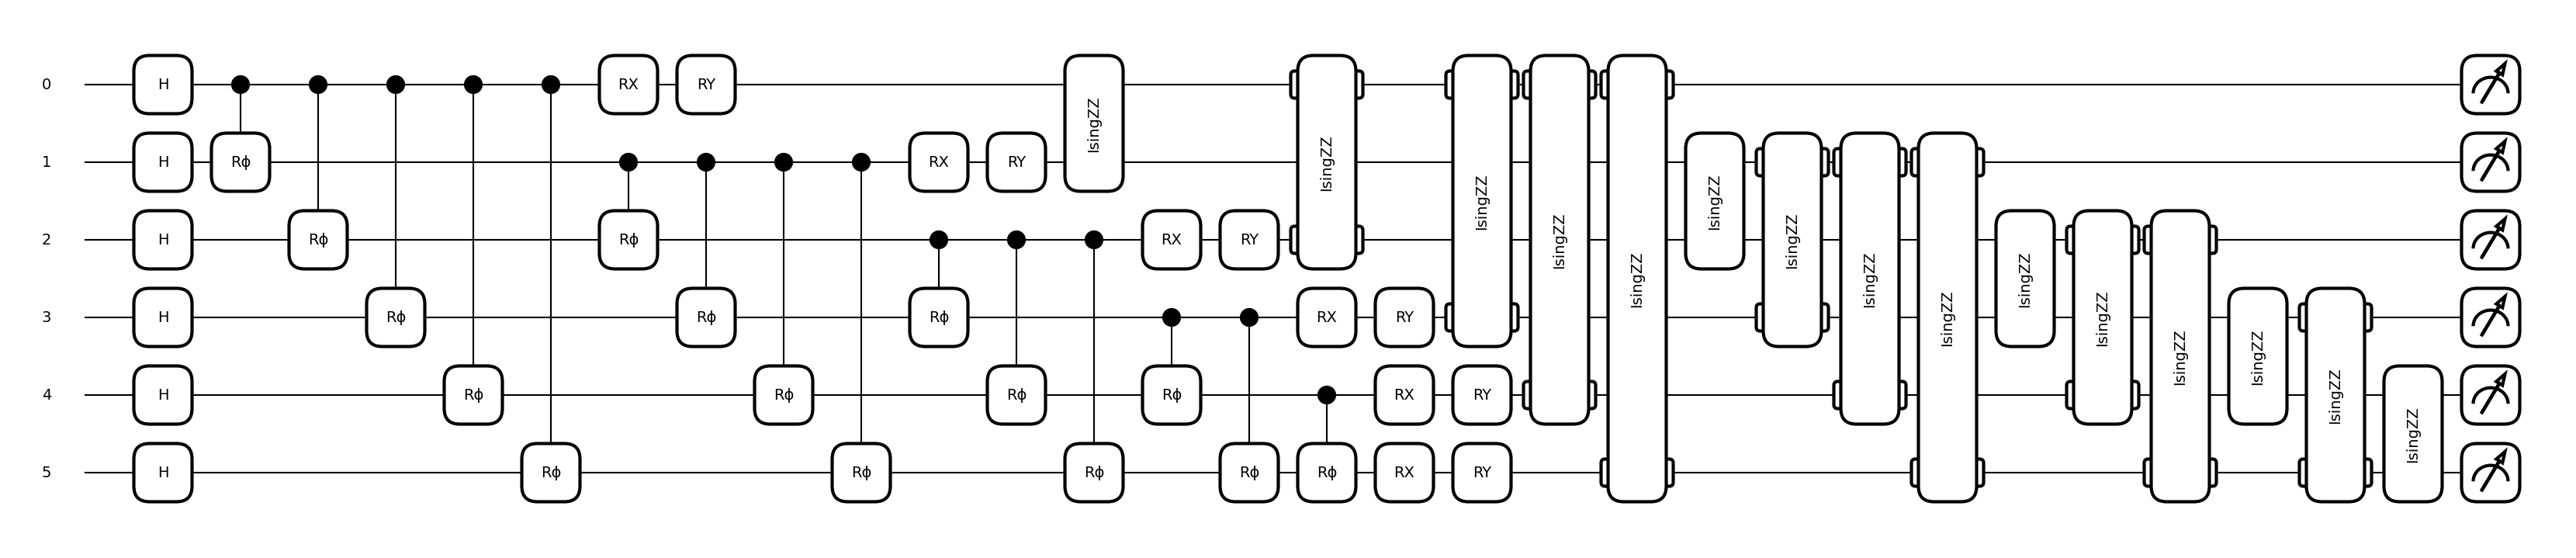

In [16]:
# Example
num_layers = 1
weights = torch.rand(num_layers, 3)
batch = torch.tensor(np.array(X[:24]))

qml.draw_mpl(Sn_circuit)(batch, weights)

(<Figure size 2400x700 with 1 Axes>, <Axes: >)

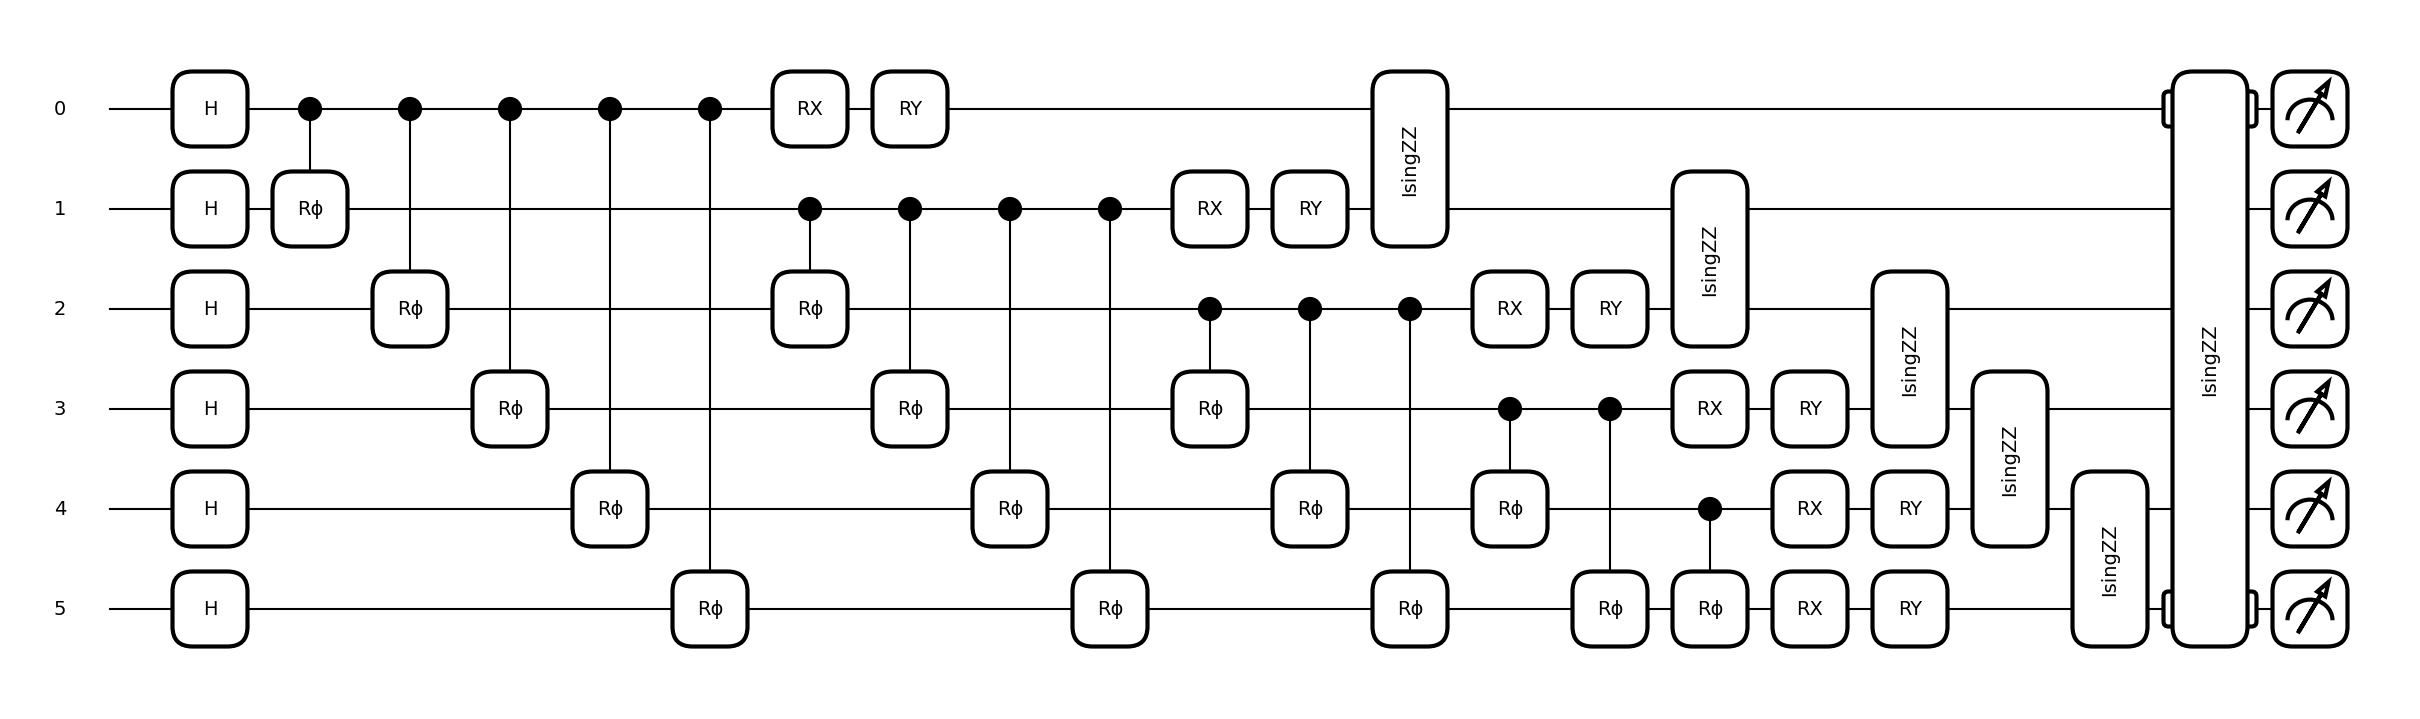

In [17]:
# Example
num_layers = 1
weights = torch.rand(num_layers, 3)
batch = torch.tensor(np.array(X[:24]))

qml.draw_mpl(Cn_circuit)(batch, weights)

(<Figure size 3000x700 with 1 Axes>, <Axes: >)

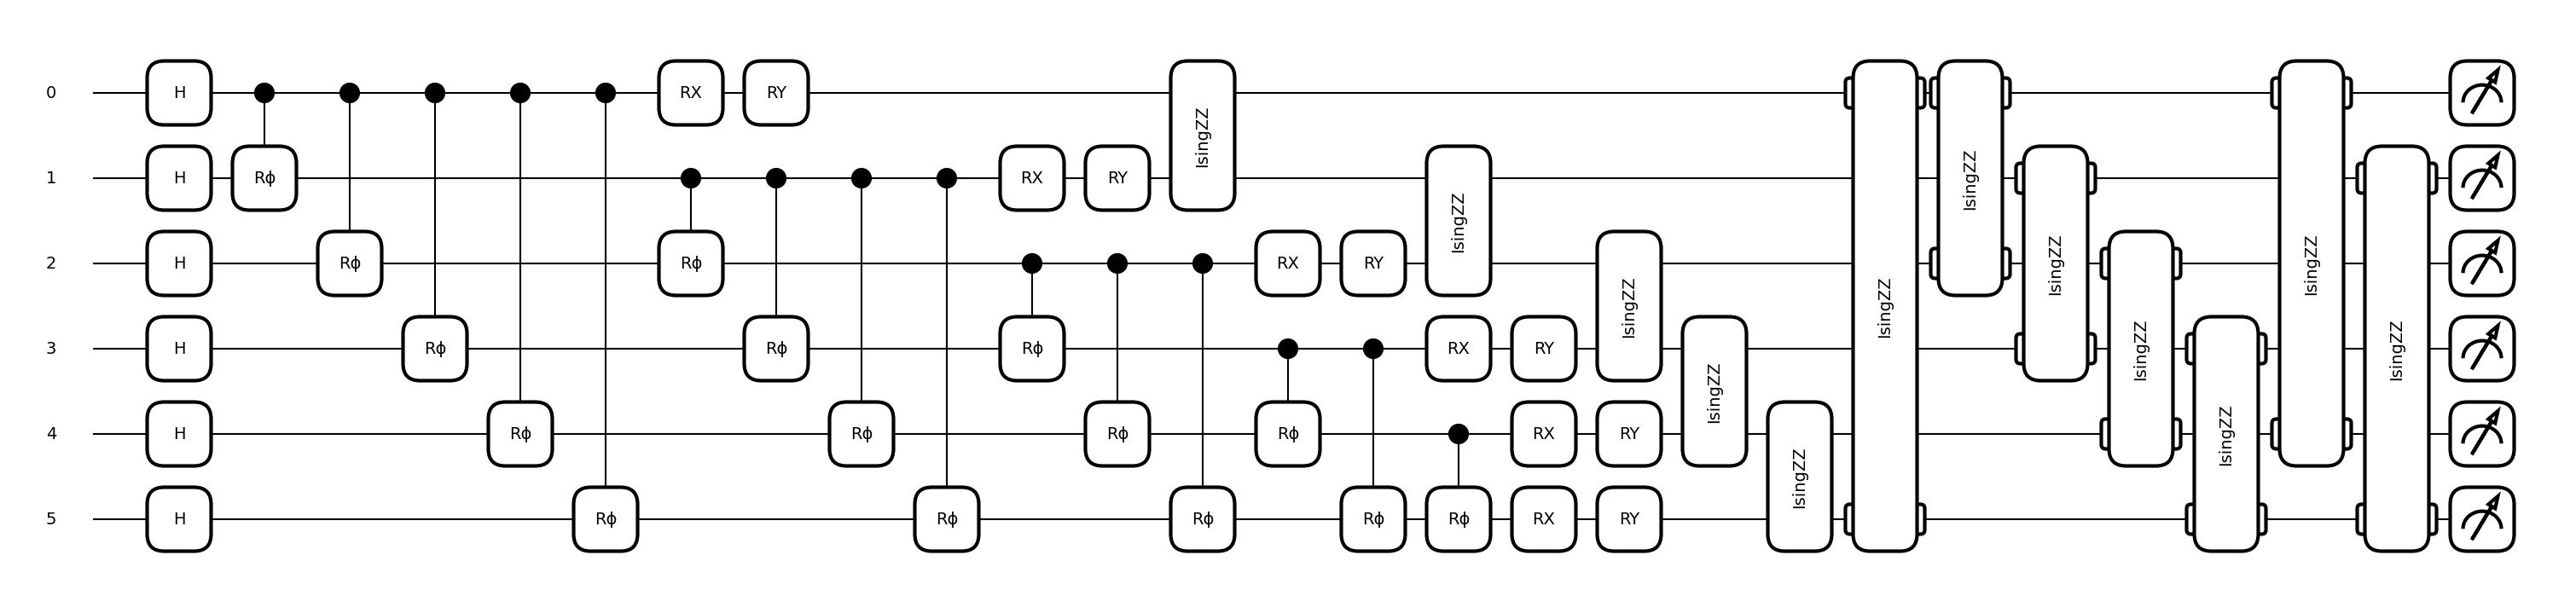

In [18]:
# Example
num_layers = 1
weights = torch.rand(num_layers, 4)
batch = torch.tensor(np.array(X[:24]))

qml.draw_mpl(Cn_circuit2)(batch, weights)

(<Figure size 2000x700 with 1 Axes>, <Axes: >)

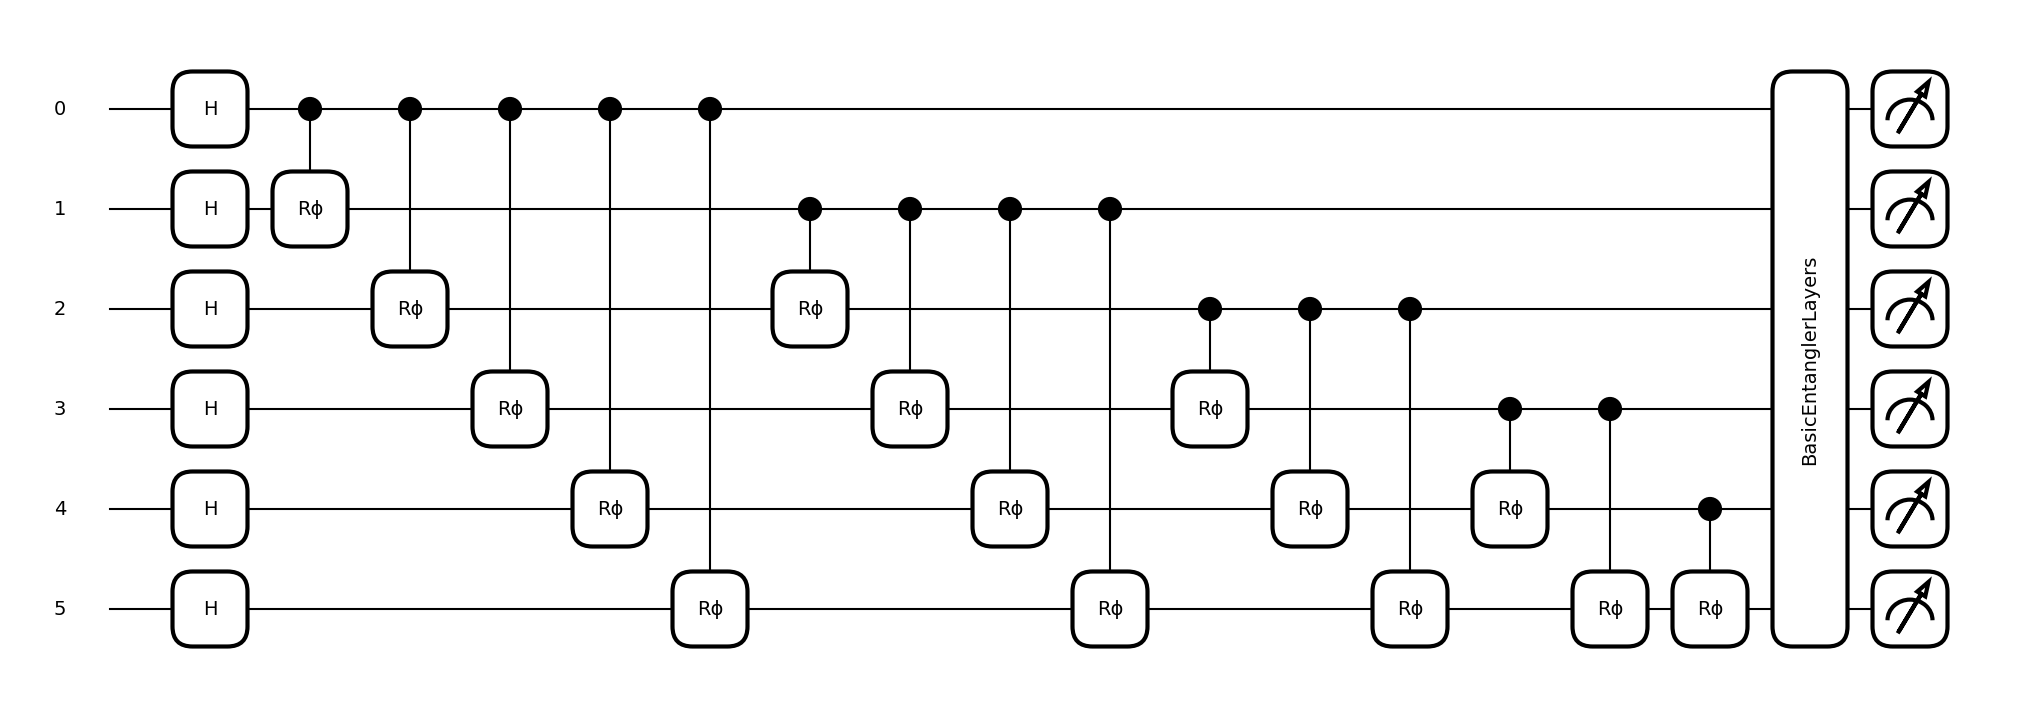

In [19]:
# Example
num_layers = 1
weights = torch.rand(num_layers, num_qubits)
batch = torch.tensor(np.array(X[:24]))

qml.draw_mpl(entanglement_circuit)(batch, weights)

(<Figure size 2000x700 with 1 Axes>, <Axes: >)

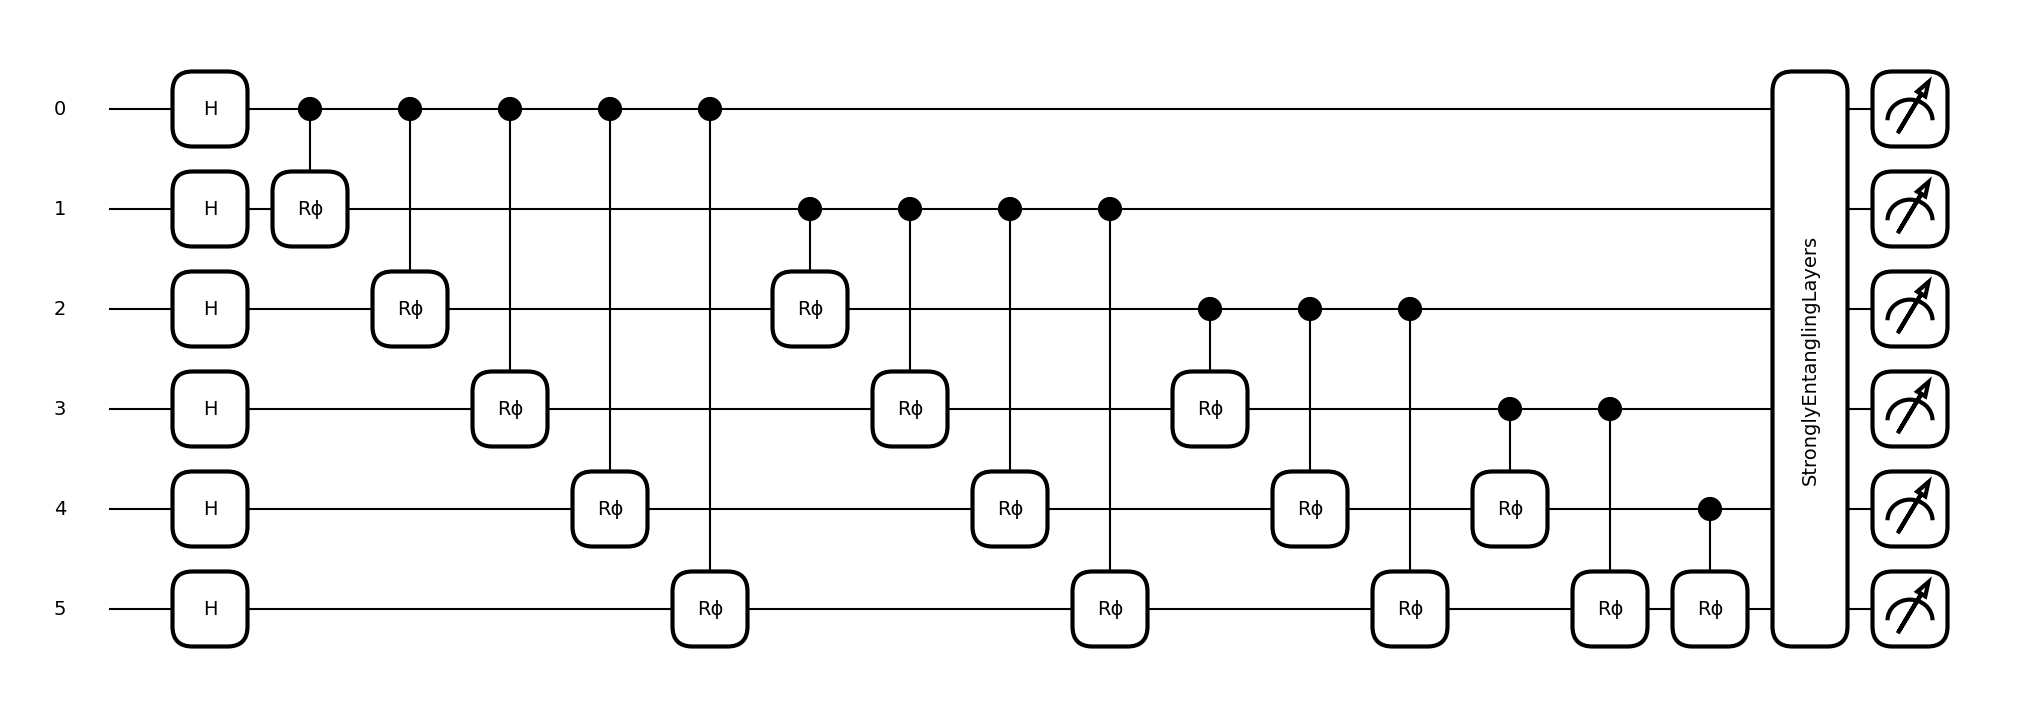

In [20]:
# Example
num_layers = 1
weights = torch.rand(num_layers, num_qubits, 3)
batch = torch.tensor(np.array(X[:24]))

qml.draw_mpl(strongly_entanglement_circuit)(batch, weights)

(<Figure size 3600x700 with 1 Axes>, <Axes: >)

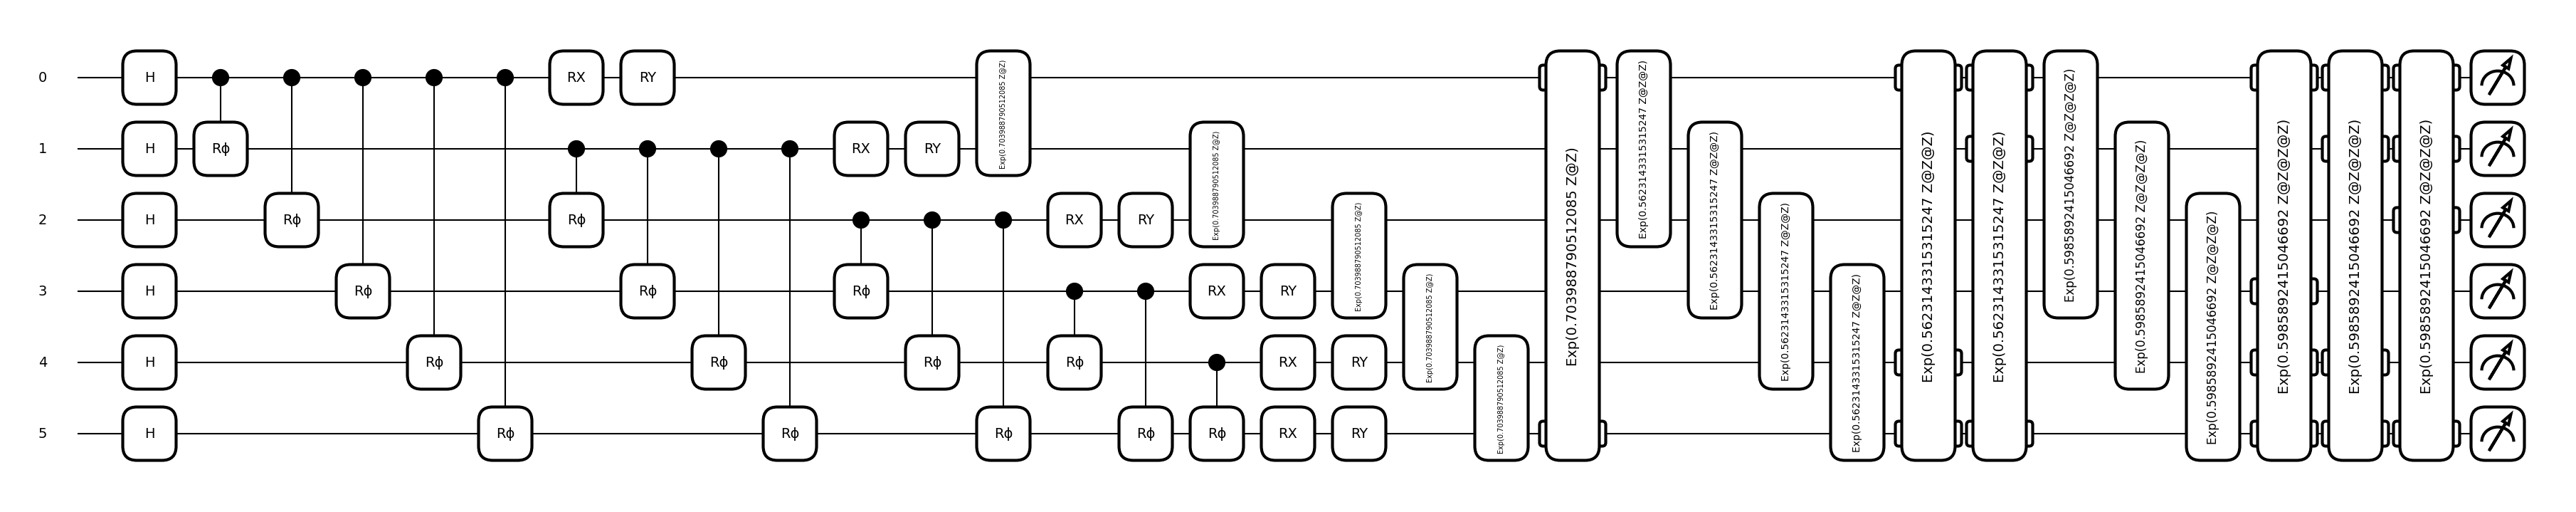

In [21]:
# Example
num_layers = 1
kbodies = 4
k = list(range(2, kbodies + 1))
weights = torch.rand(num_layers, len(k) + 2) # for each k body layer a weight and 2 weights for the first  Pauli X and Pauli Z gates
batch = torch.tensor(np.array(X[:24]))

qml.draw_mpl(k_body_Cn_circuit)(batch, weights, k)

(<Figure size 3300x700 with 1 Axes>, <Axes: >)

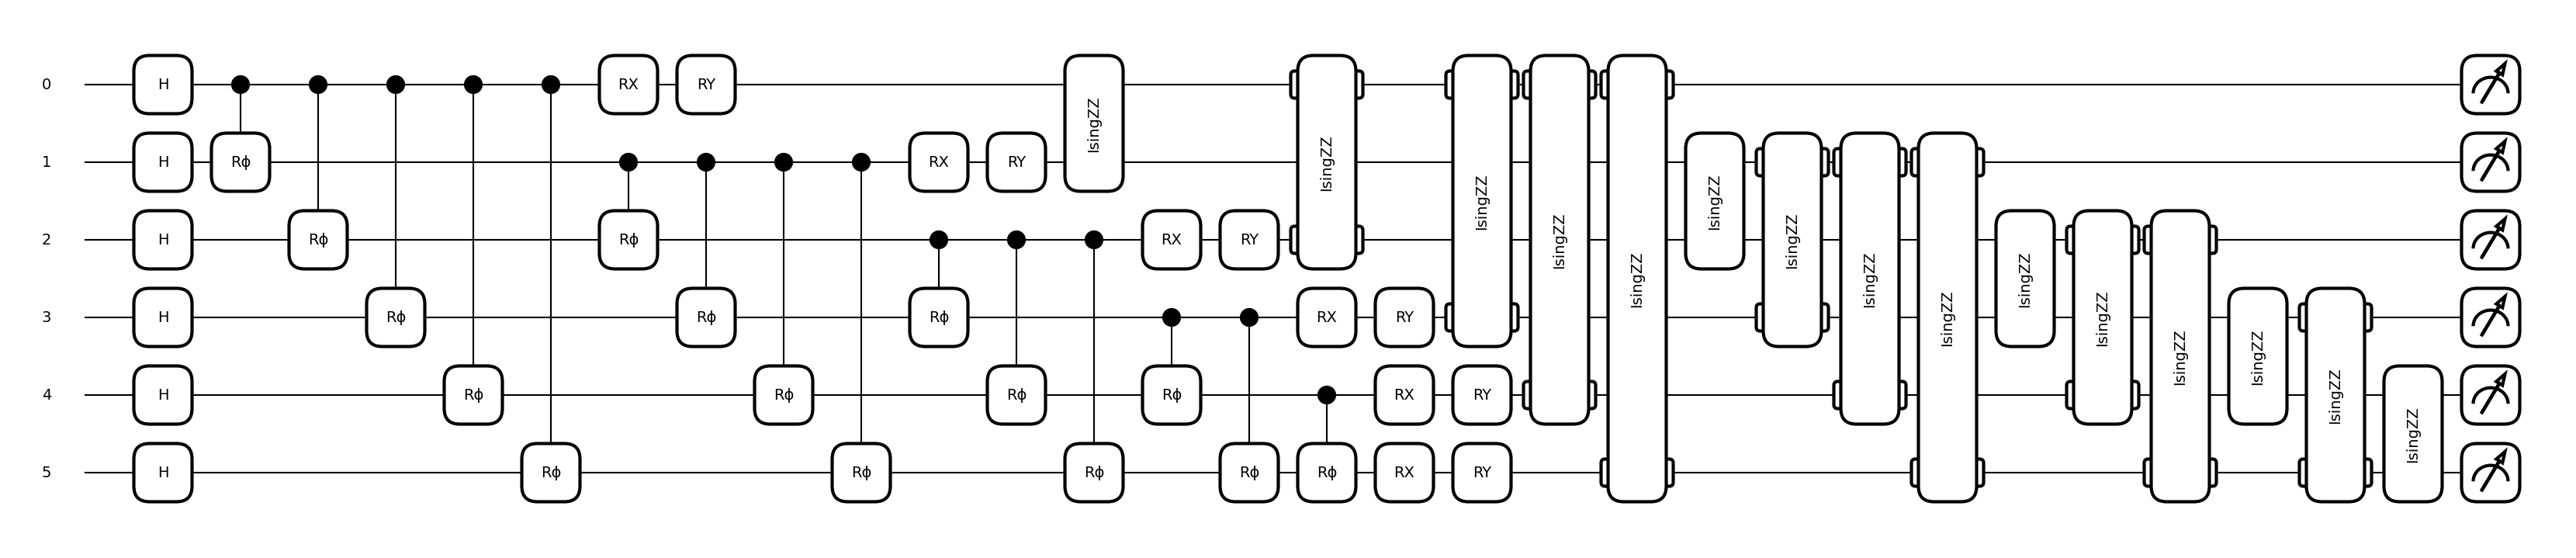

In [11]:
# Example
num_layers = 1
weights = torch.rand(num_layers, 2 + num_qubits)
batch = torch.tensor(np.array(X[:24]))

qml.draw_mpl(extended_Sn_circuit)(batch, weights)

(<Figure size 3400x700 with 1 Axes>, <Axes: >)

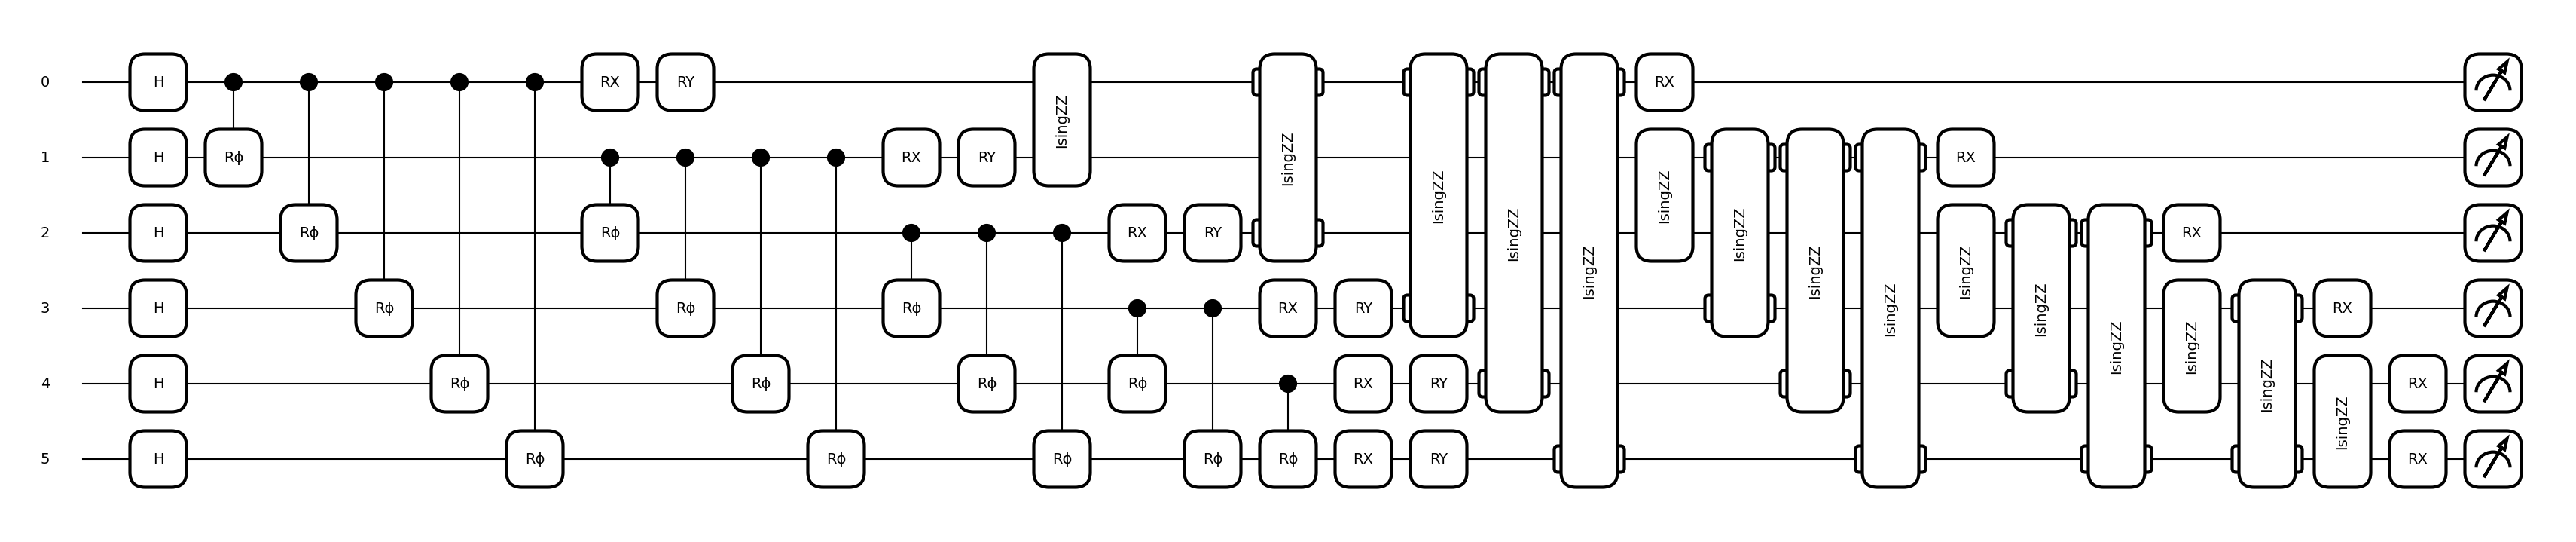

In [10]:
# Example
num_layers = 1
weights = torch.rand(num_layers, 3)
e_weights = torch.rand(num_qubits)
batch = torch.tensor(np.array(X[:24]))

qml.draw_mpl(test_extended_Sn_circuit)(batch, weights, e_weights)